In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import sys, os
sys.path.append(os.path.abspath('..'))
from pre_processamento.processamento_dados import processamento

In [25]:
df = processamento()
# --- Criar conjuntos de treino / validação / teste (por períodos) ---
# Período de treino (2010)
train_end = '2010-12-31 23:00:00'
df_train = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[:train_end]
# Período de validação (2011)
val_end = '2011-12-31 23:00:00'
val_start = '2011-01-01 00:00:00'
df_val = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[val_start:val_end]

# Período de teste (2012)
test_start = '2012-01-01 00:00:00'
df_test = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[test_start:]

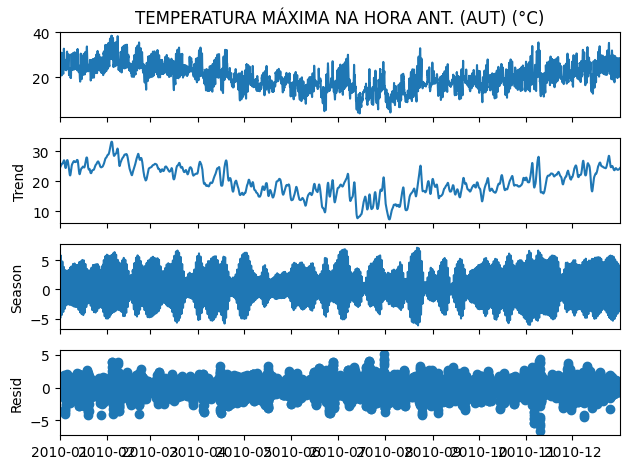

In [26]:
from statsmodels.tsa.seasonal import STL
stl = STL(df_train,period=24)
res = stl.fit()
res.plot()
plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller, kpss

In [28]:


print(f"\n=== Teste de Estacionaridade (ADF + KPSS) - {'Temperatura Máxima'} ===")

# ---- Checagens básicas ----
s = df_train


resultados = []

# ---- Testes ADF para diferentes especificações ----
modos = {
    'c' : "Constante",
    'ct': "Constante + Tendência",
    'nc': "Sem constante"
}

for reg, desc in modos.items():
    try:
        res = adfuller(s, regression=reg, autolag="AIC")
        resultados.append({
            'Modelo': desc,
            'ADF Statistic': res[0],
            'p-value': res[1],
            'Lags Usados': res[2],
            'N Obs': res[3]
        })
    except Exception as e:
        resultados.append({
            'Modelo': desc,
            'ADF Statistic': np.nan,
            'p-value': np.nan,
            'Lags Usados': np.nan,
            'N Obs': len(s),
            'Erro': str(e)
        })

df_result = pd.DataFrame(resultados)

print("\nResultados do ADF:")
display(df_result)

# ---- Teste KPSS complementar ----
print("\n=== Teste KPSS (Null = Estacionária) ===")
try:
    kpss_stat, kpss_p, _, _ = kpss(s, regression='c', nlags="auto")
    print(f"KPSS Statistic: {kpss_stat:.4f}")
    print(f"KPSS p-value : {kpss_p:.4f}")

    if kpss_p < 0.05:
        print("❗ KPSS rejeita estacionaridade → série provavelmente NÃO estacionária")
    else:
        print("✔ KPSS NÃO rejeita estacionaridade → série pode ser estacionária")
except Exception as e:
    print("Erro no KPSS:", e)

# ---- Interpretação automática ----
print("\n=== Interpretação automática ===")

adf_min_p = df_result['p-value'].min()

if adf_min_p < 0.05 and kpss_p > 0.05:
    print("➡ Conclusão forte: Série estacionária (ADF rejeita raiz unitária e KPSS aceita estacionaridade).")

elif adf_min_p < 0.05 and kpss_p < 0.05:
    print("⚠ Conclusão conflitante: ADF sugere estacionária, KPSS diz não estacionária. Tendência ou sazonalidade forte provável.")

elif adf_min_p >= 0.05:
    print("❌ ADF não rejeita raiz unitária → série provavelmente não estacionária.")

else:
    print("Caso incomum — revisar gráficos e estrutura.")



=== Teste de Estacionaridade (ADF + KPSS) - Temperatura Máxima ===

Resultados do ADF:


,Modelo,ADF Statistic,p-value,Lags Usados,N Obs,Erro
0,Constante,-6.109283,9.418029e-08,25.0,8734,NaN
1,Constante + Tendência,-6.327256,4.395516e-07,25.0,8734,NaN
2,Sem constante,NaN,NaN,NaN,8760,"regression must be one of: 'c', 'ct', 'ctt', 'n'"



=== Teste KPSS (Null = Estacionária) ===
KPSS Statistic: 4.4356
KPSS p-value : 0.0100
❗ KPSS rejeita estacionaridade → série provavelmente NÃO estacionária

=== Interpretação automática ===
⚠ Conclusão conflitante: ADF sugere estacionária, KPSS diz não estacionária. Tendência ou sazonalidade forte provável.


C:\Users\Eduardo\AppData\Local\Temp\ipykernel_2888\837309960.py:44: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(s, regression='c', nlags="auto")


In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

<Figure size 1200x500 with 0 Axes>

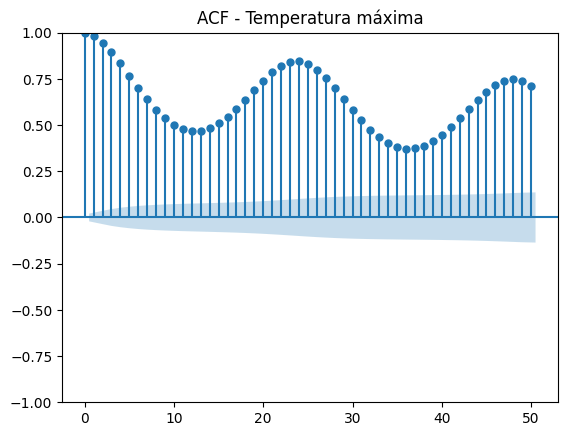

<Figure size 1200x500 with 0 Axes>

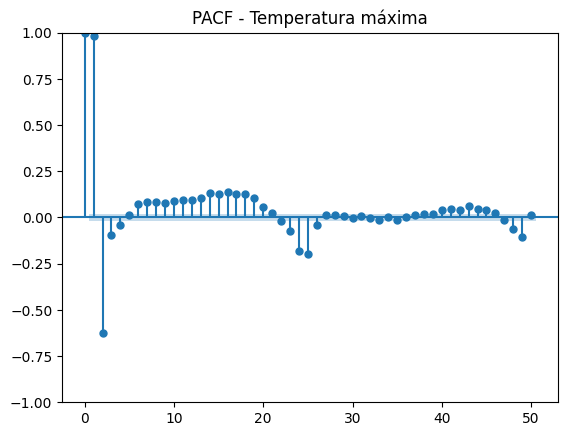

In [30]:
plt.figure(figsize=(12, 5))
plot_acf(df_train, lags=50)
plt.title(f"ACF - Temperatura máxima")
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(df_train, lags=50, method="ywm")
plt.title(f"PACF - Temperatura máxima")
plt.show()

Ao ver os resultados, temos uma incoerência entre o teste de hipótese e o gráfico ACF. Tal problema pode ocorrer devido a uma alta sazonalidade na série, o que é esperado de uma série temporal relacionada a clima.

Para resolver tal problema temos que retirar a sazonalidade da série por meio de uma diferenciação, nesse caso como as observações são por hora do dia, iremos tentar uma diferenciação de 24 observações

<Figure size 1200x500 with 0 Axes>

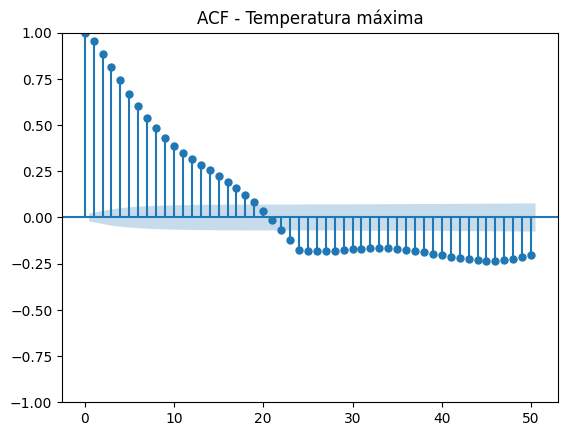

In [32]:
df_treino_diff = df_train.diff(24)
df_treino_diff.dropna(inplace=True)
plt.figure(figsize=(12, 5))
plot_acf(df_treino_diff, lags=50)
plt.title(f"ACF - Temperatura máxima")
plt.show()

Ao fazer isso há uma diferença significativa no plot da ACF e podemos dizer que agora a série está estacionária, já que dentro de 30 lags a ACF reduziu e ficou próxima de 0.

Mas se quisermos podemos testar outros valores diferenciação para ver se conseguimos uma série mais próxima de uma ACF normal que cai por volta do lag 5

<Figure size 1200x500 with 0 Axes>

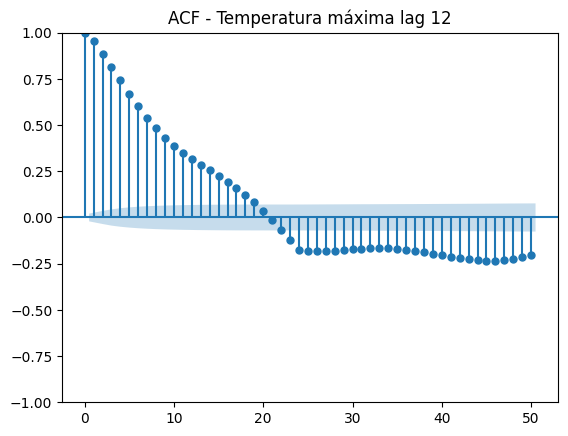

<Figure size 1200x500 with 0 Axes>

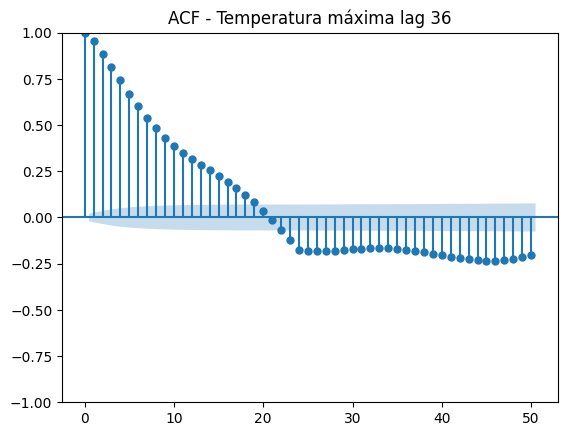

<Figure size 1200x500 with 0 Axes>

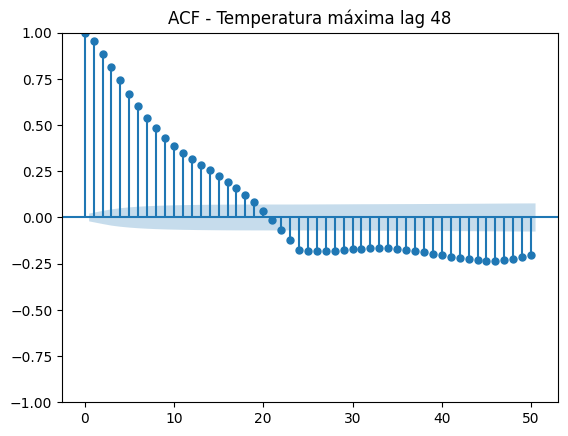

<Figure size 1200x500 with 0 Axes>

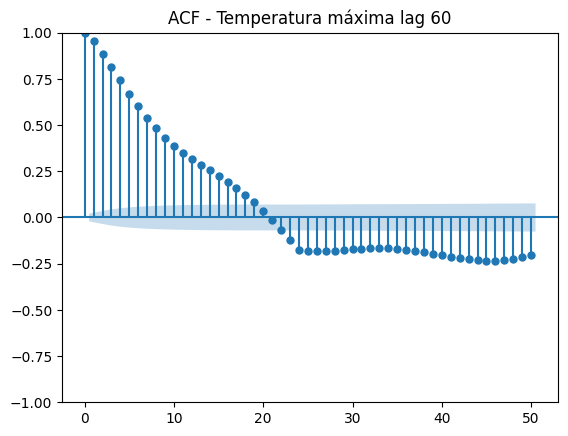

<Figure size 1200x500 with 0 Axes>

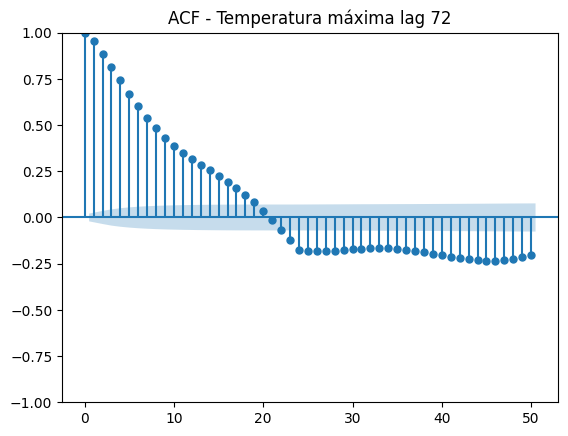

<Figure size 1200x500 with 0 Axes>

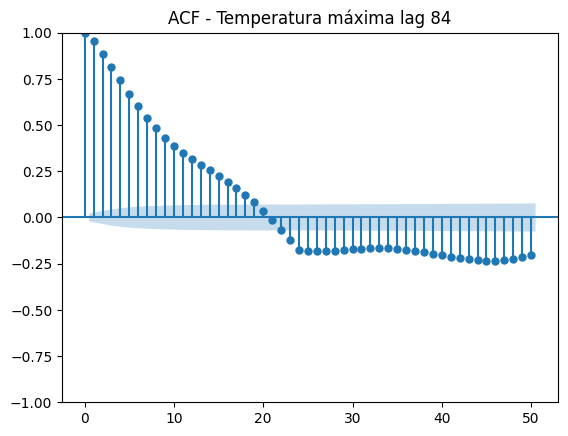

<Figure size 1200x500 with 0 Axes>

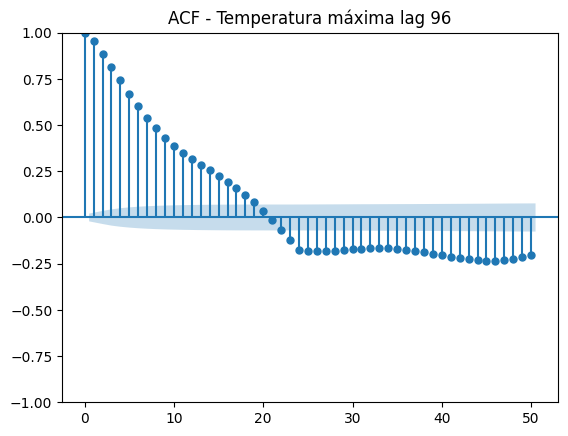

<Figure size 1200x500 with 0 Axes>

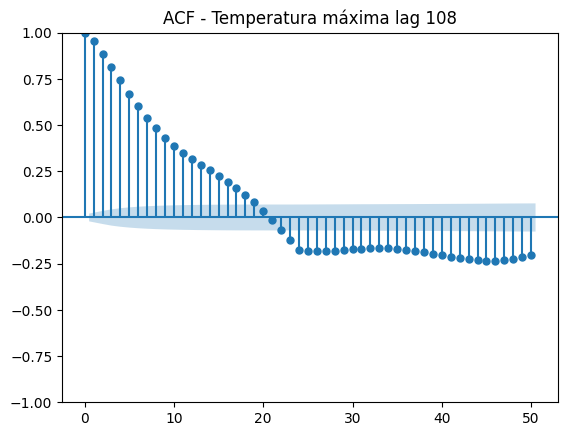

<Figure size 1200x500 with 0 Axes>

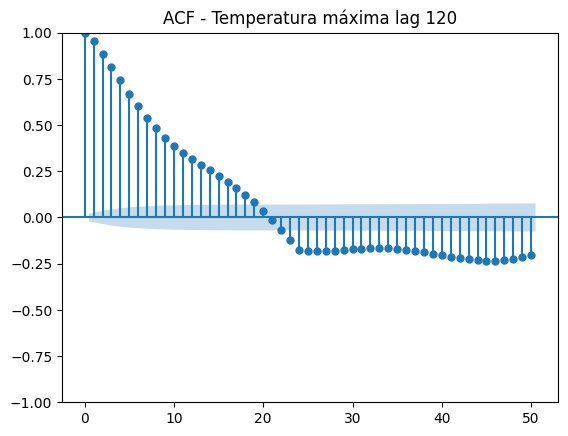

<Figure size 1200x500 with 0 Axes>

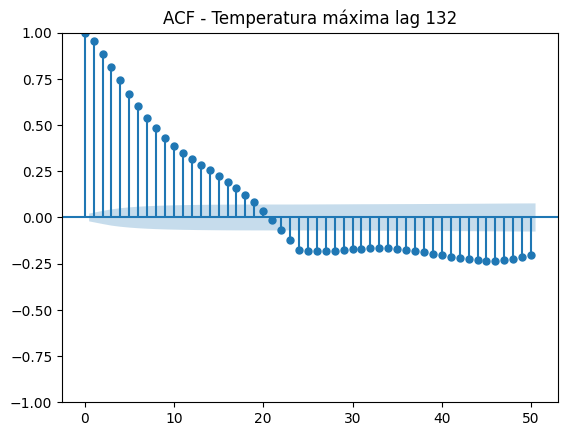

<Figure size 1200x500 with 0 Axes>

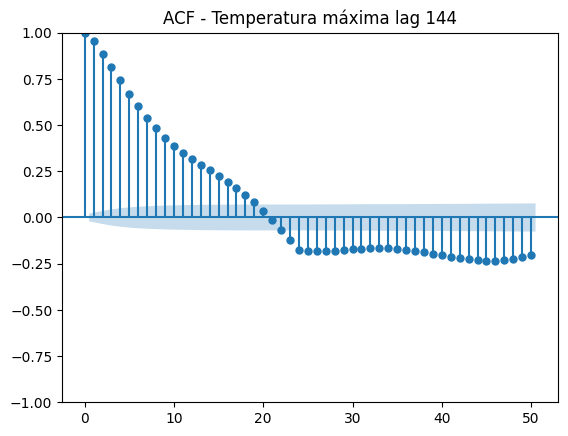

<Figure size 1200x500 with 0 Axes>

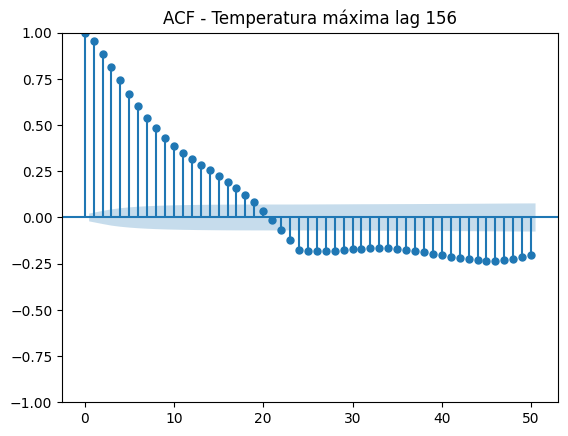

<Figure size 1200x500 with 0 Axes>

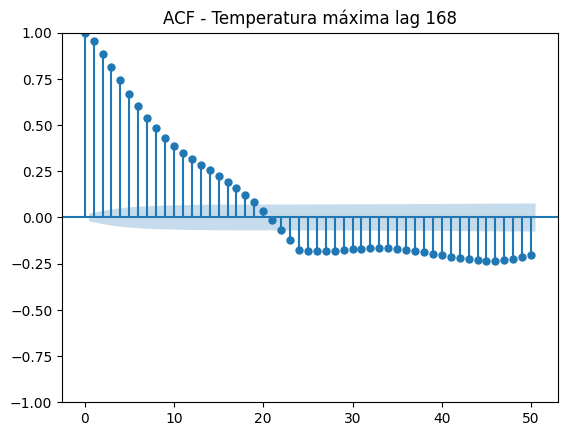

In [33]:
lag = [12, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168]
for i in lag:
  temp = df_train.diff(i)
  temp.dropna(inplace=True)
  plt.figure(figsize=(12, 5))
  plot_acf(df_treino_diff, lags=50)
  plt.title(f"ACF - Temperatura máxima lag {i}")
  plt.show()

Após o teste é possível notar que não houveram diferenças confirmando que podemos assumir 24 como a sazonalidade dessa série